### Compare fits for pct_high, pct_low, ... etc

#### 'Disabling' numba has no effect
import os
check = os.environ.get("ARCH_DISABLE_NUMBA", True)

In [37]:
import time

import numpy as np

start_time = time.time()

In [38]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://localhost',
                       connect_args={'read_default_file': '~/.myuseq.cnf'})
conn = engine.connect()

In [39]:
num_stocks="100"

import pandas as pd
tck_qry = pd.read_sql_query('''select distinct us.symbol, avg(us.volume*us.close) from USEQ_2021 us
join useq.US_syms_with_options USWO on us.symbol = USWO.Symbol
    group by us.symbol order by avg(us.volume*us.close) desc limit ''' + num_stocks,
                            conn)
tdf = pd.DataFrame(tck_qry, columns=['symbol'])
tickers = tdf['symbol']
prices = ["pct_open", "pct_high", "pct_low", "pct_close",
          'pct_hilo', 'pct_opclo']
#prices = ["pct_hilo"]

In [40]:
sql_diff = time.time() - start_time
formatted_diff = "{:.2f}".format(sql_diff)
print("sql executed in ", formatted_diff, " secs")

sql executed in  1.95  secs


In [41]:
def query_symbol(sym, conn):
    qry = pd.read_sql_query(
        '''select tradedate, pct_open, pct_high, pct_low, pct_close,
         pct_hilo, pct_opclo from USEQ_HIST
        where symbol="''' + sym + '''"
        and volume>0
         order by tradedate''',
        conn,
        index_col='tradedate'
    )
    return sym, pd.DataFrame(qry, columns=prices)

In [42]:
import math
def ann_var(var):
    return (math.sqrt((var)*252))

In [43]:
from arch import arch_model

In [44]:
rows = []
tickers=pd.concat([pd.Series(data='DFS'), tickers])
#tickers=pd.Series(data=['MS']).append(tickers)
#tickers=pd.Series(data=['BYND']).append(tickers)
#tickers=pd.Series(data=['DIS']).append(tickers)
# do_output=True
do_output=False
step = 0
steps = 201
time_last = time.time()
for tk in tickers:
    ticker, df = query_symbol(tk, conn)
    for pr in prices:
        if(len(df.index)<800):
#            print("length = ",len(df.index)," for ",tk)
            continue
        
        if do_output == True:
            if step % steps == 0:
                print("fitting symbol: ", tk, "  for price: ", pr, "len(df): ", len(df.index))
                time_now = time.time()
                time_spent = time_now - time_last
                time_last = time_now
                formatted = "{:.2f}".format(time_spent)
                print(steps, " executed in ", formatted, " secs")
        am = arch_model(df[pr], p=1, o=1, q=1, dist="StudentsT", rescale=False)
        res = am.fit(disp='off')
        if res.convergence_flag != 0:
            continue
        forecasts = res.forecast(reindex=False)
        row = [tk, pr, res.loglikelihood, ann_var(forecasts.variance['h.1'].iloc[0])
               ,forecasts.mean['h.1'].iloc[0], res.nobs]
        rows.append(row)
        step += 1
    cmp = pd.DataFrame(rows, columns=['ticker', 'price', 'lhood', 'volatilty', 'mean', 'nobs'])

compare = cmp.set_index(['ticker', 'price'])
compare.head(36)

/home/kimwoodle/mambaforge/envs/volatility/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


lhood   volatilty      mean  nobs
ticker price                                              
DFS    pct_open   -9399.338106   42.312415  0.054313  4510
       pct_high   -8824.546881   40.327438  0.078234  4510
       pct_low    -9203.280274   42.256482  0.055787  4510
       pct_close  -9472.969273   40.627320  0.073425  4510
       pct_hilo   -7930.575391   20.937531  1.864886  4510
       pct_opclo  -8653.701043   23.467644 -0.032793  4510
SPY    pct_open   -7748.362427   29.599416  0.055104  5913
       pct_high   -6730.472920   32.092785  0.067322  5913
       pct_low    -7585.706241   26.135830  0.042162  5913
       pct_close  -7897.897292   29.772746  0.058552  5913
       pct_hilo   -5888.805344    6.295220  0.907056  5913
       pct_opclo  -6702.675012    7.217330 -0.036120  5913
TSLA   pct_open   -9179.528292  307.629862  0.158493  3528
       pct_high   -8795.423955  279.898993  0.101971  3528
       pct_low    -8919.997658  295.340375  0.205263  3528
       pct_close  -9103.191205  229.110607  0.147160  3528
       pct_hilo   -7460.655970   33.905427  3.543043  3528
       pct_opclo  -8464.695511   43.155019  0.007222  3528
QQQ    pct_open   -9587.765747   71.346065  0.094519  5913
       pct_high   -8509.193015   71.183812  0.103463  5913
       pct_low    -9290.795757   67.668023  0.074618  5913
       pct_close  -9608.389589   72.730186  0.093587  5913
       pct_hilo   -7493.861189    7.630758  1.225640  5913
       pct_opclo  -8556.908748   11.155495 -0.042967  5913
AAPL   pct_open  -12485.841975  150.764125  0.149630  5913
       pct_high  -11505.082940  148.373559  0.121376  5913
       pct_low   -11931.721796  149.259706  0.152882  5913
       pct_close -12360.846217  155.968281  0.133655  5913
       pct_hilo  -10259.182559   15.970322  1.866501  5913
       pct_opclo -11235.160120   25.668641 -0.056319  5913
MSFT   pct_open  -10601.407062   74.809149  0.060628  5913
       pct_high   -9853.737035   82.134690  0.068717  5913
       pct_low   -10120.318578   82.778452  0.061979  5913
       pct_close -10820.309065   94.254270  0.063954  5913
       pct_hilo   -8124.336735   11.982724  1.598389  5913
       pct_opclo  -9620.689855   16.807892 -0.033979  5913

In [45]:
total_rows = len(cmp.index)
time_now = time.time()
elapsed_sec = time_now - start_time
elapsed_min = elapsed_sec/60.
elapsed_minf = "{:.2f}".format(elapsed_min)
elapsed_secf = "{:.2f}".format(elapsed_sec)
print(total_rows, " rows processed in ", elapsed_minf, " minutes.")
rows_per_sec = total_rows/elapsed_sec
rows_per_secf = "{:.2f}".format(rows_per_sec)
print(rows_per_secf, " rows processed per second.")

593  rows processed in  0.48  minutes.
20.63  rows processed per second.


<Axes: ylabel='Frequency'>

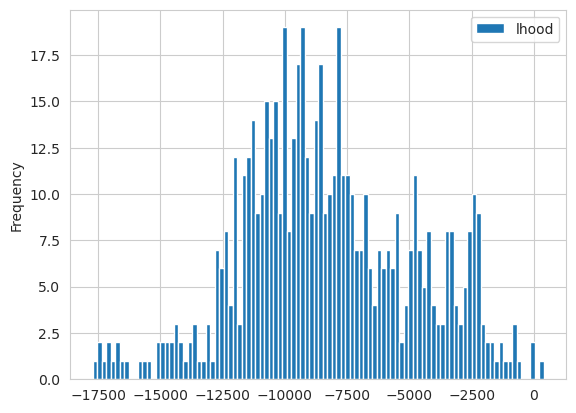

In [46]:
compare[['lhood']].plot(bins=100, kind='hist')

<Axes: ylabel='Frequency'>

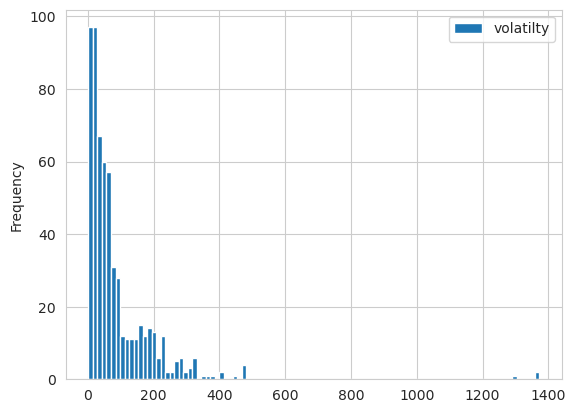

In [47]:
compare[['volatilty']].plot(bins=100, kind='hist')

In [48]:
conn.close()